In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model  

In [24]:
img_folder = 'images/'

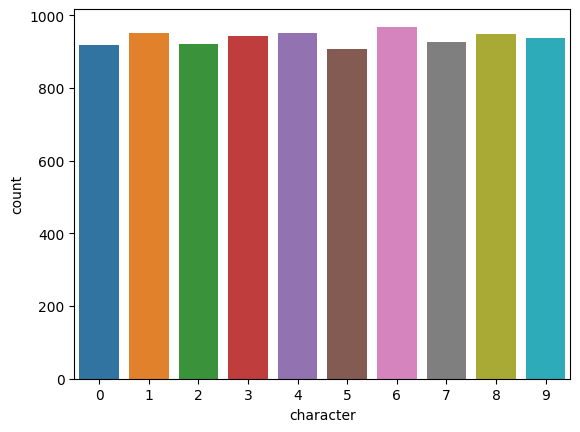

In [25]:
df = pd.DataFrame(columns=['filename','extension','label','labelsize','char1','char2','char3','char4','char5','char6'])
i = 0
for _, _, files in os.walk(img_folder):
    for f in files:
        df.loc[i,'filename'] = f
        df.loc[i,'extension'] = f.split('.')[1]
        df.loc[i,'label'] = f.split('.')[0]
        df.loc[i,'labelsize'] = len(f.split('.')[0])
        df.loc[i,'char1'] = f.split('.')[0][0]
        df.loc[i,'char2'] = f.split('.')[0][1]
        df.loc[i,'char3'] = f.split('.')[0][2]
        df.loc[i,'char4'] = f.split('.')[0][3]
        df.loc[i,'char5'] = f.split('.')[0][4]
        df.loc[i,'char6'] = f.split('.')[0][5]
        i = i+1
        
#df.head()

data = pd.DataFrame(df['char1'].value_counts()+df['char2'].value_counts()+df['char3'].value_counts()+df['char4'].value_counts()+df['char5'].value_counts()+df['char6'].value_counts()).reset_index()
data.columns = ['character','count']

sns.barplot(data=data, x='character', y='count')
plt.show()

In [26]:
def compute_perf_metric(predictions, groundtruth):
    if predictions.shape == groundtruth.shape:
        return np.sum(predictions == groundtruth)/(predictions.shape[0]*predictions.shape[1])
    else:
        raise Exception('Error : the size of the arrays do not match. Cannot compute the performance metric')

<div style="display:fill; background-color:#000000;border-radius:5px;">
    <p style="font-size:300%; color:white;text-align:center";>Creation of the training and validation datasets</p>
</div>

In [27]:
# Dictionaries that will be used to convert characters to integers and vice-versa
vocabulary = {'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'}
char_to_num = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}



# vocabulary = {'0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 
#               'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
#               'W', 'X', 'Y', 'Z'}
# char_to_num = {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
#                'A': 36, 'B': 37, 'C': 38, 'D': 39, 'E': 40, 'F': 41, 'G': 42, 'H': 43, 'I': 44,
#                'J': 45, 'K': 46, 'L': 47, 'M': 48, 'N': 49, 'O': 50, 'P': 51, 'Q': 52, 'R': 53,
#                'S': 54, 'T': 55, 'U': 56, 'V': 57, 'W': 58, 'X': 59, 'Y': 60, 'Z': 61}


##############################################################################################################################
# This function encodes a single sample.
# Inputs :
# - img_path : the string representing the image path e.g. '/kaggle/input/captcha-version-2-images/samples/samples/6n6gg.jpg'
# - label : the string representing the label e.g. '6n6gg'
# - crop : boolean, if True the image is cropped around the characters and resized to the original size.
# Outputs :
# - a multi-dimensional array reprensenting the image. Its shape is (50, 200, 1)
# - an array of integers representing the label after encoding the characters to integer. E.g [6,16,6,14,14] for '6n6gg' 
##############################################################################################################################
def encode_single_sample(img_path, label, crop):
    # Read image file and returns a tensor with dtype=string
    img = tf.io.read_file(img_path)
    # Decode and convert to grayscale (this conversion does not cause any information lost and reduces the size of the tensor)
    # This decode function returns a tensor with dtype=uint8
    img = tf.io.decode_png(img, channels=1)
    # Scales and returns a tensor with dtype=float32
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Crop and resize to the original size : 
    # top-left corner = offset_height, offset_width in image = 0, 25 
    # lower-right corner is at offset_height + target_height, offset_width + target_width = 50, 150


    if(crop==True):
        img = tf.image.crop_to_bounding_box(img, offset_height=0, offset_width=25, target_height=50, target_width=125)
        img = tf.image.resize(img,size=[50,200],method='bilinear', preserve_aspect_ratio=False,antialias=False, name=None)


    # Transpose the image because we want the time dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # Converts the string label into an array with 5 integers. E.g. '6n6gg' is converted into [6,16,6,14,14]
    label = list(map(lambda p:char_to_num[p], label))
    return img.numpy(), label

def create_train_and_validation_datasets(crop=False):
    # Loop on all the files to create X whose shape is (1040, 50, 200, 1) and y whose shape is (1040, 5)
    X, y = [],[]

    for _, _, files in os.walk(img_folder):
        for f in files:
            # To start, let's ignore the jpg images
            label = f.split('.')[0]
            extension = f.split('.')[1]
            if extension=='png':
                img, label = encode_single_sample(img_folder+f, label,crop)
                X.append(img)
                y.append(label)

    X = np.array(X)
    y = np.array(y)

    # Split X, y to get X_train, y_train, X_val, y_val 
    # X_train, X_val, y_train, y_val = train_test_split(X.reshape(1040, 10000), y, test_size=0.1, shuffle=True, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42)
    # X_train, X_val = X_train.reshape(936,200,50,1), X_val.reshape(104,200,50,1)

    return X_train, X_val, y_train, y_val

In [28]:
# X_train, X_val, y_train, y_val = create_train_and_validation_datasets(crop=True)
# X_train_, X_val_, y_train_, y_val_ = create_train_and_validation_datasets(crop=False)

# fig=plt.figure(figsize=(20, 10))
# fig.add_subplot(2, 4, 1)
# plt.imshow(X_train[0], cmap='gray')
# #plt.imshow(X_train[0].transpose((1,0,2)), cmap='gray')
# plt.title('Image from X_train with label '+ str(y_train[0]))
# plt.axis('off')
# fig.add_subplot(2, 4, 2)
# plt.imshow(X_train[935], cmap='gray')
# #plt.imshow(X_train[935].transpose((1,0,2)), cmap='gray')
# plt.title('Image from X_train with label '+ str(y_train[935]))
# plt.axis('off')
# fig.add_subplot(2, 4, 3)
# plt.imshow(X_val[0], cmap='gray')
# #plt.imshow(X_val[0].transpose((1,0,2)), cmap='gray')
# plt.title('Image from X_val with label '+ str(y_val[0]))
# plt.axis('off')
# fig.add_subplot(2, 4, 4)
# plt.imshow(X_val[103], cmap='gray')
# # plt.imshow(X_val[103].transpose((1,0,2)), cmap='gray')
# plt.title('Image from X_val with label '+ str(y_val[103]))
# plt.axis('off')
# fig.add_subplot(2, 4, 5)
# plt.imshow(X_train_[0], cmap='gray')
# plt.title('Image from X_train with label '+ str(y_train_[0]))
# plt.axis('off')
# fig.add_subplot(2, 4, 6)
# plt.imshow(X_train_[935], cmap='gray')
# plt.title('Image from X_train with label '+ str(y_train_[935]))
# plt.axis('off')
# fig.add_subplot(2, 4, 7)
# plt.imshow(X_val_[0], cmap='gray')
# plt.title('Image from X_val with label '+ str(y_val_[0]))
# plt.axis('off')
# fig.add_subplot(2, 4, 8)
# plt.imshow(X_val_[103], cmap='gray')
# plt.title('Image from X_val with label '+ str(y_val_[103]))
# plt.axis('off')
# plt.show()

## Build Model

In [29]:
def build_model():
    
    # Inputs to the model
    input_img = layers.Input(shape=(200,50,1), name="image", dtype="float32") 

    # First conv block
    x = layers.Conv2D(32,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv1")(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)
  
    # Second conv block
    x = layers.Conv2D(64,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv2")(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    #Dropout Layer
    x = layers.Dropout(0.5)(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64 --> output volume shape = (50,12,64) 
    # Reshape to "split" the volume in 5 time-steps
    x = layers.Reshape(target_shape=(6, 6400), name="reshape")(x)

    # FC layers
    x = layers.Dense(256, activation="relu", name="dense1")(x)
    x = layers.Dense(64, activation="relu", name="dense2")(x)
   
    # Output layer
    output = layers.Dense(10, activation="softmax", name="dense3")(x)
    
    # Define the model
    model = keras.models.Model(inputs=input_img, outputs=output, name="ocr_classifier_based_model")

    # lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=10000, decay_rate=0.9)
    # optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
    
    # Compile the model and return
    model.compile(optimizer=keras.optimizers.Adam(), loss="sparse_categorical_crossentropy", metrics="accuracy")
    return model

# Get the model
model = build_model()
model.summary()


Model: "ocr_classifier_based_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 6, 6

In [30]:
# def build_model():
    
#     # Inputs to the model
#     input_img = layers.Input(shape=(200,50,1), name="image", dtype="float32") 

#     # First conv block
#     x = layers.Conv2D(64,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv1")(input_img)
#     x = layers.BatchNormalization()(x)
#     x = layers.MaxPooling2D((2, 2), name="pool1")(x)
#     x = layers.Dropout(0.25)(x)

#     # Second conv block
#     x = layers.Conv2D(128,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv2")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.MaxPooling2D((2, 2), name="pool2")(x)
#     x = layers.Dropout(0.25)(x)

#     # Third conv block
#     x = layers.Conv2D(256,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv3")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.MaxPooling2D((2, 2), name="pool3")(x)
#     x = layers.Dropout(0.25)(x)

#     # Flatten and FC layers
#     x = layers.Flatten()(x)
#     x = layers.Dense(512, activation="relu", name="dense1")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.5)(x)
#     x = layers.Dense(128, activation="relu", name="dense2")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dropout(0.5)(x)

#     # Output layer
#     output = layers.Dense(5, activation="softmax", name="dense3")(x)
    
#     # Define the model
#     model = keras.models.Model(inputs=input_img, outputs=output, name="captcha_cracking_model")
    
#     # Use a learning rate schedule
#     lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=10000, decay_rate=0.9)
#     optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

#     # Compile the model and return
#     model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
#     return model

# # Get the model
# model = build_model()
# model.summary()


## Train the model

In [32]:
X_train, X_val, y_train, y_val = create_train_and_validation_datasets(crop=False)
history = model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=15)

Epoch 1/15
44/44 [==============================] - 11s 238ms/step - loss: 0.0189 - accuracy: 0.9968 - val_loss: 0.0113 - val_accuracy: 0.9979
Epoch 2/15
44/44 [==============================] - 11s 240ms/step - loss: 0.0195 - accuracy: 0.9964 - val_loss: 0.0118 - val_accuracy: 0.9979
Epoch 3/15
44/44 [==============================] - 11s 242ms/step - loss: 0.0211 - accuracy: 0.9959 - val_loss: 0.0127 - val_accuracy: 0.9989
Epoch 4/15
44/44 [==============================] - 11s 240ms/step - loss: 0.0177 - accuracy: 0.9963 - val_loss: 0.0099 - val_accuracy: 0.9979
Epoch 5/15
44/44 [==============================] - 11s 245ms/step - loss: 0.0171 - accuracy: 0.9966 - val_loss: 0.0098 - val_accuracy: 0.9989
Epoch 6/15
44/44 [==============================] - 11s 243ms/step - loss: 0.0137 - accuracy: 0.9973 - val_loss: 0.0103 - val_accuracy: 0.9979
Epoch 7/15
44/44 [==============================] - 11s 246ms/step - loss: 0.0165 - accuracy: 0.9967 - val_loss: 0.0087 - val_accuracy: 0.9979

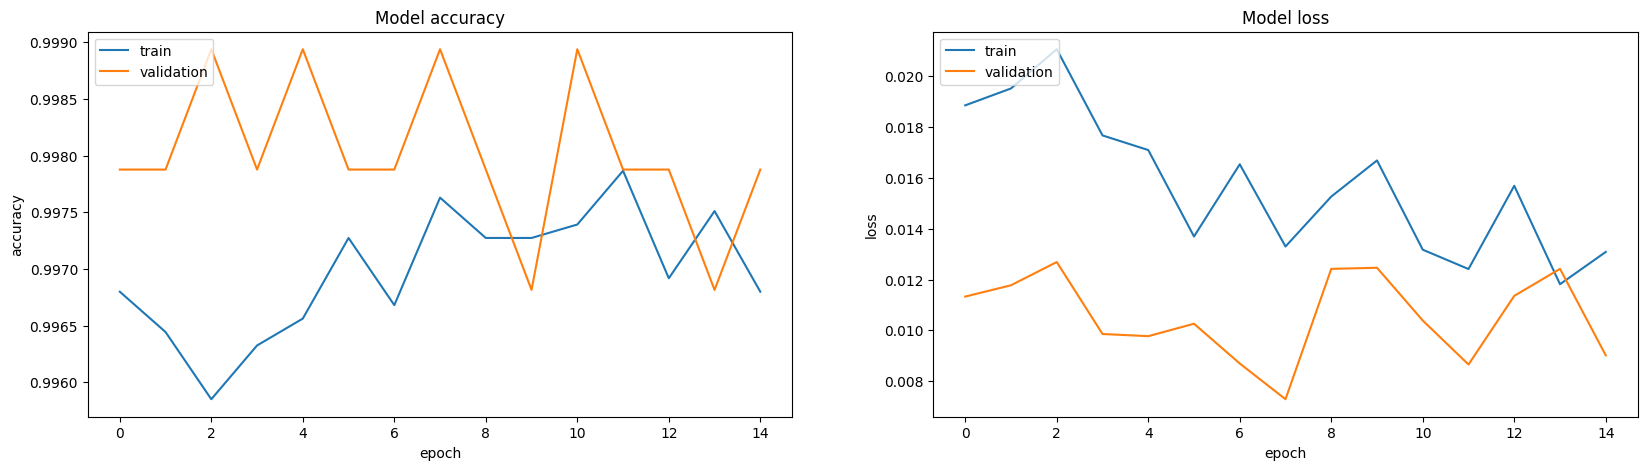

In [33]:
fig=plt.figure(figsize=(20, 5))
# summarize history for accuracy
fig.add_subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# summarize history for loss
fig.add_subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Predictions

Let's use this model to predict the labels for the 104 images of the validation set :

5/5 [==============================] - 0s 62ms/step


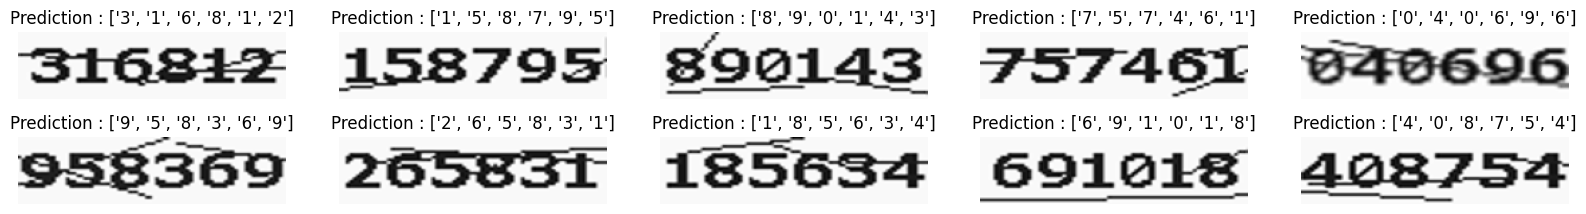

In [34]:
y_pred = model.predict(X_val) # y_pred shape = (104,50,19)
# y_pred = model.predict([X_val, np.zeros((X_val.shape[0], 37))])

# y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1], -1)

y_pred = np.argmax(y_pred, axis=2)
# num_to_char = {'-1':'UKN','0':'2','1':'3','2':'4','3':'5','4':'6','5':'7','6':'8','7':'b','8':'c','9':'d','10':'e','11':'f','12':'g','13':'m','14':'n','15':'p','16':'w','17':'x','18':'y'}

num_to_char = {'-1': 'UKN', '0': '0', '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9'}


# num_to_char = {'-1': 'UKN', '0': '0', '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9', 
#                '36': 'A', '37': 'B', '38': 'C', '39': 'D', 
#                '40': 'E', '41': 'F', '42': 'G', '43': 'H', '44': 'I', '45': 'J', '46': 'K', '47': 'L', '48': 'M', '49': 'N', 
#                '50': 'O', '51': 'P', '52': 'Q', '53': 'R', '54': 'S', '55': 'T', '56': 'U', '57': 'V', '58': 'W', '59': 'X', 
#                '60': 'Y', '61': 'Z'}

nrow = 1
fig=plt.figure(figsize=(20, 5))
for i in range(0,10):
    if i>4: nrow = 2
    fig.add_subplot(nrow, 5, i+1)
    plt.imshow(X_val[i].transpose((1,0,2)),cmap='gray')
    plt.title('Prediction : ' + str(list(map(lambda x:num_to_char[str(x)], y_pred[i]))))
    plt.axis('off')
plt.show()

(1, 200, 50, 1)
1/1 [==============================] - 0s 28ms/step
Prediction : ['1', '5', '6', '4', '8', '5']


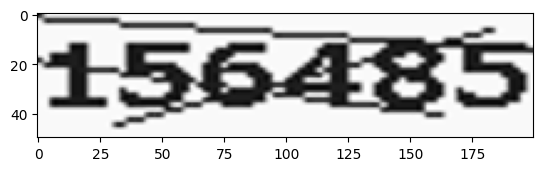

In [35]:
# model = load_model('Model_30Perc.h5')
model.save('Model_KFINTECH.h5')

# img = "D:/Captcha/qlye3.png"
img = "D:/Captcha-crack/KFintech Captcha/156485.png"

a,b = encode_single_sample(img,"52919",False)
  
X=[]
X.append(a)
X=np.array(X)

print(X.shape)

y_pred = model.predict(X)
y_pred = np.argmax(y_pred,axis=2)
num_to_char = {'-1': 'UKN', '0': '0', '1': '1', '2': '2', '3': '3', '4': '4', '5': '5', '6': '6', '7': '7', '8': '8', '9': '9'}

print('Prediction : ' + str(list(map(lambda x:num_to_char[str(x)], y_pred[0]))))

plt.imshow(X[0].transpose((1,0,2)),cmap='gray')
plt.show()

<div style="display:fill; background-color:#000000;border-radius:5px;">
    <p style="font-size:300%; color:white;text-align:center";>References</p>
</div>

https://machinelearningmastery.com/cnn-long-short-term-memory-networks/  
https://keras.io/examples/vision/captcha_ocr/   
https://www.tensorflow.org/guide/keras/rnn  
https://towardsdatascience.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c